<a href="https://colab.research.google.com/github/kenclements/praxis/blob/main/adaboost-twos3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Tue Feb 21 01:13:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    29W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import string
import re

#Vectorization and Tokenizing
from tensorflow.keras import layers

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MaxAbsScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import InputLayer
import torch
from tensorflow.keras import losses
from tensorflow.keras.regularizers import L2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import TextVectorization

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer

#Models
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression


#Metrics and Testing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [5]:
# file1 = pd.read_csv('/Data/TWOS-dataset/email_ano/User1.csv')
# file2 = pd.read_csv('/Data/TWOS-dataset/email_ano/User2.csv')
# file3 = pd.read_csv('/Data/TWOS-dataset/email_ano/User3.csv')
# file4 = pd.read_csv('/Data/TWOS-dataset/email_ano/User4.csv')
# file6 = pd.read_csv('/Data/TWOS-dataset/email_ano/User6.csv')
# file7 = pd.read_csv('/Data/TWOS-dataset/email_ano/User7.csv')
# file8 = pd.read_csv('/Data/TWOS-dataset/email_ano/User8.csv')
# file9 = pd.read_csv('/Data/TWOS-dataset/email_ano/User9.csv')
# file10 = pd.read_csv('/Data/TWOS-dataset/email_ano/User10.csv')
# file11 = pd.read_csv('/Data/TWOS-dataset/email_ano/User11.csv')
# file12 = pd.read_csv('/Data/TWOS-dataset/email_ano/User12.csv')
# file13 = pd.read_csv('/Data/TWOS-dataset/email_ano/User13.csv')
# file14 = pd.read_csv('/Data/TWOS-dataset/email_ano/User14.csv')
# file15 = pd.read_csv('/Data/TWOS-dataset/email_ano/User15.csv')
# file16 = pd.read_csv('/Data/TWOS-dataset/email_ano/User16.csv')
# file17 = pd.read_csv('/Data/TWOS-dataset/email_ano/User17.csv')
# file18 = pd.read_csv('/Data/TWOS-dataset/email_ano/User18.csv')
# file19 = pd.read_csv('/Data/TWOS-dataset/email_ano/User19.csv')
# file20 = pd.read_csv('/Data/TWOS-dataset/email_ano/User20.csv')
# file21 = pd.read_csv('/Data/TWOS-dataset/email_ano/User21.csv')
# file22 = pd.read_csv('/Data/TWOS-dataset/email_ano/User22.csv')
# file23 = pd.read_csv('/Data/TWOS-dataset/email_ano/User23.csv')
# combined = pd.read_csv('/Data/TWOS-dataset/email_ano/combined.csv')
#test = pd.read_csv('/Data/TWOS-dataset/email_ano/test.csv')
#train = pd.read_csv('/Data/TWOS-dataset/email_ano/train.csv')
#imdb = pd.read_csv('/Data/TWOS-dataset/email_ano/IMDB Dataset.csv')
df = pd.read_csv('/content/drive/MyDrive/Praxis/data/IMDB Dataset.csv')



In [6]:
#df = pd.concat([file1, file2, file3, file4, file6, file7, file8, file9, file10, file11, file12, file13, file14, file15, file16, file17, file18, file19, file20, file21, file22, file23])

In [7]:
df.rename(columns={"review": "body_anon", "sentiment": "label"}, inplace=True)

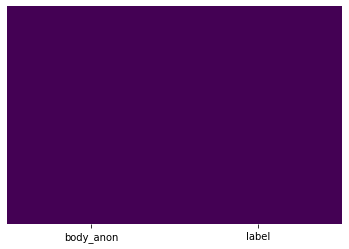

In [8]:
sb.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [9]:
df.dropna(subset=['label'], inplace=True)


In [10]:
def prep(dfx):
    dfx1 = [re.sub(r'[^\w\s]','', x) for x in dfx]
    dfx1 = ''.join(dfx1)
    return(dfx1)

#df1 = df['body_anon'].apply(prep)

In [11]:
nltk.download('stopwords')
stops = set(stopwords.words('english'))
#print(stops)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
def prepare_text(pretext):

    # tokenize mission.
    tokens = word_tokenize(pretext, language="english", preserve_line=True)

    # Parts of speech (POS) tag tokens.
    token_tag = pos_tag(tokens)
    
    # Only include some of the POS tags.
    include_tags = ['VBN', 'VBD', 'JJ', 'JJS', 'JJR', 'CD', 'NN', 'NNS', 'NNP', 'NNPS']
    filtered_tokens = (tok for tok, tag in token_tag if tag in include_tags)    
    #stem words.
    stemmed_tokens = (lancaster.stem(tok) for tok in filtered_tokens)

    #lemm words.
    lemmed_words = (lemmatizer.lemmatize(tok) for tok in stemmed_tokens)

    lower_words = [str.lower(tok) for tok in lemmed_words]

    #x = cv.fit_transform(tokens).toarray()

    joined = " ".join(lower_words);

    return(joined)

    #ps = PorterStemmer()
lancaster = LancasterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()
    
#df['tokenized'] = df['body_anon'].apply(prepare_text)
df['tokenized'] = df['body_anon']



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [13]:
df.head(1)


,body_anon,label,tokenized
0,One of the other reviewers has mentioned that ...,positive,One of the other reviewers has mentioned that ...


In [14]:
# countvectorizer = CountVectorizer(analyzer= 'word', stop_words='english')
# tfidfvectorizer = TfidfVectorizer(stop_words=None, analyzer='word' )

In [15]:
# count_wm = countvectorizer.fit_transform(df['body_anon'])
# tfidf_wm = tfidfvectorizer.fit_transform(df['tokenized'])


In [16]:
#count_tokens = countvectorizer.get_feature_names_out()
#tfidf_tokens = tfidfvectorizer.get_feature_names_out()

In [17]:
# df_countvect = pd.DataFrame(data = count_wm.toarray(),columns = count_tokens)
# df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),columns = tfidf_tokens)
# print("Count Vectorizer\n")
# print(df_countvect)
# print("\nTD-IDF Vectorizer\n")
# print(df_tfidfvect)

In [18]:
# df = df.reset_index(drop=True)


In [19]:
# print(df.loc[50, 'tokenized'])

In [20]:

# print(tfidf_wm[50])


In [21]:
#transformer = MaxAbsScaler().fit(tfidf_wm)
#tfidf_wm = transformer.transform(tfidf_wm)

In [22]:
# print(tfidf_wm[50])

In [23]:
# Split dataset into training set and test set
#X_train, X_test, y_train, y_test = train_test_split(tfidf_wm, df['label'], test_size=.9) # 70% training and 30% test


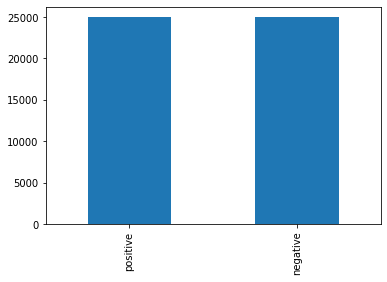

In [24]:
df['label'].value_counts().plot(kind='bar')

In [25]:
df['label'] = df['label'].map({'positive': 1, 'negative': 0})

In [26]:
train, test = train_test_split(df, test_size=0.2, stratify=df['label'])
train, validation = train_test_split(train, test_size=0.2, stratify=train['label'])

train.shape, validation.shape, test.shape

((32000, 3), (8000, 3), (10000, 3))

In [27]:
training_dataset = tf.data.Dataset.from_tensor_slices(
    (train['body_anon'].values, train['label'].values)).batch(batch_size=32)

validation_dataset = tf.data.Dataset.from_tensor_slices(
    (validation['body_anon'].values, validation['label'].values)).batch(batch_size=32)

In [32]:
vocab_size = 10000       

tfidf_vectorizer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='tf_idf'
)

tfidf_vectorizer.adapt(train['body_anon'].values)



**This is the Keras TF-IDF vectorization method**

In [ ]:
# text_vectorizer = layers.TextVectorization(output_mode="tf-idf")
# text_vectorizer.adapt(df['tokenized'])
# keras_vector = text_vectorizer(df['tokenized']).numpy()
# X_train, X_test, y_train, y_test = train_test_split(keras_vector, df['label'], test_size=.3) # 70% training and 30% test


ADABOOST MODEL

In [ ]:
# # Create adaboost classifer object
# abc = AdaBoostClassifier(n_estimators=50, learning_rate=1) 
# # Train Adaboost Classifer
# model = abc.fit(X_train, y_train)

# #Predict the response for test dataset
# y_pred = model.predict(X_test)


In [ ]:
# print("Accuracy:", metrics.accuracy_score(y_test, y_pred))


In [ ]:
# confusion_matrix(y_test, y_pred)

In [ ]:
# metrics.recall_score(y_test, y_pred)

In [48]:
model = Sequential()

model.add(tfidf_vectorizer)
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [49]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 10000)            1         
 ectorization)                                                   
                                                                 
 dense_4 (Dense)             (None, 64)                640064    
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 640,130
Trainable params: 640,129
Non-trainable params: 1
_________________________________________________________________


In [50]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.05)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# a = X_train.tocoo()

In [ ]:
# values = a.data
# indices = np.vstack((a.row, a.col))

# i = torch.LongTensor(indices)
# v = torch.FloatTensor(values)
# shape = a.shape

# b = torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense()

In [ ]:
# c = tf.convert_to_tensor(X_train.shape[0], dtype=tf.float32)

In [51]:
history = model.fit(training_dataset, epochs=5, validation_data=validation_dataset)

Epoch 1/5
1000/1000 [==============================] - 9s 8ms/step - loss: 0.5565 - accuracy: 0.7918 - val_loss: 0.4801 - val_accuracy: 0.8075
Epoch 2/5
1000/1000 [==============================] - 7s 7ms/step - loss: 0.4193 - accuracy: 0.8506 - val_loss: 0.6233 - val_accuracy: 0.8345
Epoch 3/5
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3450 - accuracy: 0.8584 - val_loss: 0.4819 - val_accuracy: 0.7857
Epoch 4/5
1000/1000 [==============================] - 7s 7ms/step - loss: 0.3538 - accuracy: 0.8255 - val_loss: 0.5394 - val_accuracy: 0.7768
Epoch 5/5
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3313 - accuracy: 0.8460 - val_loss: 1.1660 - val_accuracy: 0.7473


KNN Model

In [ ]:
# K = []
# training = []
# test = []
# scores = {}
  
# for k in range(2, 5):
#     clf = KNeighborsClassifier(n_neighbors = k)
#     clf.fit(X_train, y_train)
  
#     training_score = clf.score(X_train, y_train)
#     test_score = clf.score(X_test, y_test)
#     K.append(k)
  
#     training.append(training_score)
#     test.append(test_score)
#     scores[k] = [training_score, test_score]

In [ ]:
# scores

In [ ]:
# clf = KNeighborsClassifier(n_neighbors=2)
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)

In [ ]:
# y_pred

In [ ]:
# print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

In [ ]:
# confusion_matrix(y_test, y_pred)

In [ ]:
# plt.scatter(K, training, color ='k')
# plt.scatter(K, test, color ='g')
# plt.show()
# # For overlapping scatter plots

In [ ]:
# svm = SVC(kernel="poly", degree=1, gamma="scale")

In [ ]:
# svm.fit(X_train, y_train)

In [ ]:
# y_pred = svm.predict(X_test)

In [ ]:
# confusion_matrix(y_test, y_pred)

In [ ]:
# lr = LogisticRegression()

In [ ]:
# lr.fit(X_train, y_train)

In [ ]:
# y_pred = lr.predict(X_test)

In [ ]:
# y_pred

In [ ]:
# confusion_matrix(y_test, y_pred)

In [ ]:
# y_train_hat_probs = lr.predict_proba(X_test)[:,1]

In [ ]:
# y_train_hat_probs

In [ ]:
# nb = GaussianNB()

In [ ]:
# nb.fit(X_train.toarray(), y_train)

In [ ]:
# y_pred = nb.predict(X_test.toarray())

In [ ]:
# y_pred

In [ ]:
# confusion_matrix(y_test, y_pred)